In [0]:
from scipy.io import arff
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as D
import matplotlib.pyplot as plt

In [0]:
genre, meta = arff.loadarff('/content/Genre.arff')

In [0]:
df = pd.DataFrame(genre)

In [0]:
df["highlevel_speech_music_value"] = df["highlevel_speech_music_value"].str.decode('utf-8')
df["highlevel_voice_instrumental_value"] = df["highlevel_voice_instrumental_value"].str.decode('utf-8')
df["genre"] = df["genre"].str.decode('utf-8')
df["tonal_key_mode_value"] = df["tonal_key_mode_value"].str.decode('utf-8')


In [0]:
cleanup_nums = {"highlevel_speech_music_value":{"music": 0, "speech": 1},
                "highlevel_voice_instrumental_value": {"instrumental": 0, "voice": 1 },
                "tonal_key_mode_value": {"minor": 0, "major": 1 },
                "genre":{"blu":0, "cla":1, "cou":2, "dis":3, "hip":4, "jaz":5, "met":6, "pop":7, "reg":8, "roc":9}}
df_encoded = df.replace(cleanup_nums, inplace=False)
df_onehot_1 = pd.get_dummies(df_encoded,columns=['highlevel_speech_music_value',
                                        'highlevel_voice_instrumental_value',
                                        'tonal_key_mode_value'])
cols = list(df_onehot_1.columns)
df_onehot_1=df_onehot_1[cols[:237] + cols[238:] + [cols[237]]]

In [0]:
#normalized_df=(df-df.min())/(df.max()-df.min())

In [0]:
df_onehot_1.head()

,highlevel_danceability_value,highlevel_equalization_profile_value,highlevel_excitement_value,highlevel_intensity_value,loudness_dynamic_complexity_dvar,loudness_dynamic_complexity_mean,loudness_dynamic_complexity_var,loudness_larm_dvar,loudness_larm_mean,loudness_larm_var,loudness_replay_gain_value,loudness_vicker_dvar,loudness_vicker_mean,loudness_vicker_var,rhythm_beats_loudness_bass_dvar,rhythm_beats_loudness_bass_mean,rhythm_beats_loudness_bass_var,rhythm_beats_loudness_dvar,rhythm_beats_loudness_mean,rhythm_beats_loudness_var,rhythm_onset_rate_value,spectral_barkbands_00_dvar,spectral_barkbands_00_mean,spectral_barkbands_00_var,spectral_barkbands_01_dvar,spectral_barkbands_01_mean,spectral_barkbands_01_var,spectral_barkbands_02_dvar,spectral_barkbands_02_mean,spectral_barkbands_02_var,spectral_barkbands_03_dvar,spectral_barkbands_03_mean,spectral_barkbands_03_var,spectral_barkbands_04_dvar,spectral_barkbands_04_mean,spectral_barkbands_04_var,spectral_barkbands_05_dvar,spectral_barkbands_05_mean,spectral_barkbands_05_var,spectral_barkbands_06_dvar,...,spectral_silence_rate_60dB_var,spectral_skewness_dvar,spectral_skewness_mean,spectral_skewness_var,spectral_spread_dvar,spectral_spread_mean,spectral_spread_var,spectral_strongpeak_dvar,spectral_strongpeak_mean,spectral_strongpeak_var,temporal_zerocrossingrate_dvar,temporal_zerocrossingrate_mean,temporal_zerocrossingrate_var,tempotap_bpm_estimates_dvar,tempotap_bpm_estimates_mean,tempotap_bpm_estimates_var,tempotap_bpm_value,timbral_complexity_dvar,timbral_complexity_mean,timbral_complexity_var,tonal_chords_changes_rate_value,tonal_chords_dissonance_dvar,tonal_chords_dissonance_mean,tonal_chords_dissonance_var,tonal_chords_number_rate_value,tonal_chords_strength_dvar,tonal_chords_strength_mean,tonal_chords_strength_var,tonal_dissonance_dvar,tonal_dissonance_mean,tonal_dissonance_var,tonal_key_strength_value,tonal_tuning_equal_tempered_deviation_value,highlevel_speech_music_value_0,highlevel_speech_music_value_1,highlevel_voice_instrumental_value_0,highlevel_voice_instrumental_value_1,tonal_key_mode_value_0,tonal_key_mode_value_1,genre
0,0.206472,0.372766,0.029087,0.093526,-0.411385,0.024215,-0.201421,-0.532833,0.702348,-0.304162,-0.024487,-0.846413,0.919727,-0.750326,-0.172460,0.929212,-0.261089,-0.193266,0.694974,-0.231590,0.478116,-0.115289,0.002534,-0.160331,-0.003445,0.862221,-0.052989,-0.261717,0.249193,-0.279313,-0.442601,-0.002635,-0.325319,0.006353,1.310631,0.386974,-0.248731,-0.455313,-0.277999,1.341961,...,-0.093268,-0.344900,-0.140824,-0.345782,0.017402,-0.124781,0.172126,0.171313,1.278099,-0.230627,-0.633999,-0.892049,-0.759252,0.434289,-1.691921,0.378448,-1.068684,-0.112090,-0.135098,-0.236251,0.814246,-0.266199,0.297177,-0.230311,-1.407427,-0.255337,1.140774,-1.490395,0.494393,0.149725,-0.013634,0.526779,-0.205793,1,0,0,1,1,0,0
1,-0.368479,0.372766,1.341977,0.093526,-0.349921,-0.015672,-0.173045,-0.452769,-0.365326,-0.330522,-0.050286,-0.885979,0.578624,-0.993143,-0.419147,-0.315975,-0.164839,-0.358631,-0.504920,-0.397909,-0.741369,-0.222598,-0.588028,-0.227662,-0.300875,-0.658818,-0.334130,-0.306309,-0.366649,-0.342895,-0.421833,-0.382409,-0.402336,-0.359020,-0.567930,-0.381362,-0.273538,-0.510434,-0.294455,-0.566908,...,-0.093268,-0.460114,-0.774049,-0.395388,-0.730034,0.029227,-0.879273,-0.580647,-0.013611,-0.674982,-0.366133,0.251808,0.066906,-0.852510,0.413868,-0.731175,0.357418,-0.711714,-0.259751,-0.964501,-0.055100,-0.510019,-0.319468,-0.512892,-0.636402,-0.121114,0.497749,-0.901662,0.347729,-0.517640,0.184709,-0.129683,-0.667979,1,0,0,1,0,1,0
2,-0.631747,0.372766,-1.283803,-1.324366,4.235612,5.779127,3.973258,1.713613,-1.889279,0.416157,-0.311997,-0.564181,-1.454938,-0.847100,0.661237,0.477024,2.104009,-0.347312,-1.356588,-0.389079,-1.894935,-0.220981,-0.480847,-0.226534,-0.314596,-0.850496,-0.353619,-0.354199,-1.063422,-0.422780,-0.581570,-1.274615,-0.612241,-0.054996,-0.520139,0.494719,-0.471552,-0.862222,-0.310716,-0.273401,...,-0.093268,0.178100,0.

In [0]:
targets_df = df_onehot_1[df_onehot_1.columns[243]]
targets = targets_df.values
torch_targets = torch.tensor(targets,dtype=torch.float64)
torch_features = torch.tensor(df_onehot_1[df_onehot_1.columns[:243]].values)
dataset = D.TensorDataset(torch_features,torch_targets)
train_size = int(0.8 * len(dataset))
test_size = (len(dataset) - train_size)//2
val_size = (len(dataset) - train_size) - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = D.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = D.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
testloader = D.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
all_loader = D.DataLoader(dataset, batch_size=1, shuffle=False)

In [0]:
class Fc_1(nn.Module):
  def __init__(self):
    super(Fc_1, self).__init__()
    self.fc1 = nn.Linear(243,256)
    self.fc3 = nn.Linear(256,256)
    self.fc2 = nn.Linear(256,10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc3(x))
    x = F.leaky_relu(self.fc2(x))
    return x

In [0]:
class Fc_2(nn.Module):
  def __init__(self):
    super(Fc_2, self).__init__()
    self.fc1 = nn.Linear(243,256)
    self.fc2 = nn.Linear(256,10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    return x

In [0]:
def train(net,train_loader,criterion,optimizer,epoch):
  for epoch in range(epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = net(inputs.float())
          loss = criterion(outputs, labels.long())
          loss.backward()
          optimizer.step()
          running_loss += loss.item()


In [0]:
def train_valcheck(net,train_loader,val_loader,criterion,optimizer,epoch):
  train_loss_array = np.array([])
  val_loss_array = np.array([])
  for epoch in range(epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = net(inputs.float())
          loss = criterion(outputs, labels.long())
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      train_loss_array = np.append(train_loss_array, running_loss)
      with torch.no_grad():
          for i, data in enumerate(val_loader,0):
              inputs, labels = data
              val_loss = criterion(net(inputs.float()),labels.long())
              val_loss_array = np.append(val_loss_array, val_loss.item())
  return train_loss_array, val_loss_array
  #print('Finished Training')
  #plt.plot(loss_array)

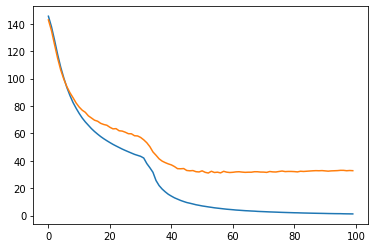

In [0]:
net = Fc_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9)
epoch = 100
train_loss, val_loss = train_valcheck(net,train_loader,val_loader,criterion, optimizer, epoch)
plt.plot(train_loss)
plt.plot(64*val_loss)

## overfitting after epoch 25

train acc:  99.6875
val acc:  88.75


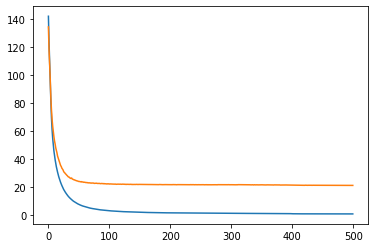

In [0]:
net = Fc_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9,weight_decay = 0.001)
epoch = 500
train_loss, val_loss = train_valcheck(net,train_loader,val_loader,criterion, optimizer, epoch)
plt.plot(train_loss)
plt.plot(64*val_loss)
print("train acc: ",test(net,train_loader))
print("val acc: ",test(net,val_loader))
# training accuracy being so high shows that model has enough capacity.
# This shows, training set is NOT representing validation set well.
# Stratified splitting can be used, to have equal distribution of classes in datasets
# adding weight decay (L2 regularization) improves val. accuracy by 1 percent

In [0]:
def test(net,testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          features, labels = data
          outputs = net(features.float())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  return accuracy

In [0]:
def kfold_cv(model,k,dataset,epoch):
  k_array = (1/k)*np.ones([k],dtype=np.int32)*len(dataset)
  k_array = k_array.astype(int)
  folds = torch.utils.data.random_split(dataset,k_array.tolist())
  acc_array = []
  
  for i in range(k):
      net = model()
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9, weight_decay = 0.001)

      valset = folds[i]
      trainset = torch.utils.data.ConcatDataset(folds[:i] + folds[i+1:])

      train_loader = D.DataLoader(trainset, batch_size=10, shuffle=False)
      valloader = D.DataLoader(valset, batch_size=1, shuffle=False)

      train(net,train_loader,criterion,optimizer,epoch)
      acc = test(net,valloader)
      acc_train = test(net,train_loader)
      acc_array.append(acc)
      print("Train acc", acc_train)
      print("Accuracy of",i,"st fold is % ", acc)
  print("Average accuracy: ", np.mean(acc_array))
  return acc_array, net


In [0]:
model = Fc_1
acc, net1 = kfold_cv(model,10,dataset,150)

Train acc 100.0
Accuracy of 0 st fold is %  86.25
Train acc 100.0
Accuracy of 1 st fold is %  78.75
Train acc 100.0
Accuracy of 2 st fold is %  86.25
Train acc 100.0
Accuracy of 3 st fold is %  88.75
Train acc 99.86111111111111
Accuracy of 4 st fold is %  87.5
Train acc 99.86111111111111
Accuracy of 5 st fold is %  86.25
Train acc 99.86111111111111
Accuracy of 6 st fold is %  81.25
Train acc 99.86111111111111
Accuracy of 7 st fold is %  81.25
Train acc 99.86111111111111
Accuracy of 8 st fold is %  82.5
Train acc 100.0
Accuracy of 9 st fold is %  86.25


In [0]:
model = Fc_2
acc, net2 = kfold_cv(model,10,dataset,150)

Train acc 99.86111111111111
Accuracy of 0 st fold is %  81.25
Train acc 99.86111111111111
Accuracy of 1 st fold is %  82.5
Train acc 100.0
Accuracy of 2 st fold is %  82.5
Train acc 99.86111111111111
Accuracy of 3 st fold is %  81.25
Train acc 99.86111111111111
Accuracy of 4 st fold is %  87.5
Train acc 99.72222222222223
Accuracy of 5 st fold is %  86.25
Train acc 99.86111111111111
Accuracy of 6 st fold is %  80.0
Train acc 99.72222222222223
Accuracy of 7 st fold is %  87.5
Train acc 99.72222222222223
Accuracy of 8 st fold is %  85.0
Train acc 99.86111111111111
Accuracy of 9 st fold is %  85.0


In [0]:
model = Fc_2
acc, net2 = kfold_cv(model,10,dataset,500)

Train acc 99.86111111111111
Accuracy of 0 st fold is %  85.0
Train acc 100.0
Accuracy of 1 st fold is %  82.5
Train acc 99.86111111111111
Accuracy of 2 st fold is %  83.75
Train acc 99.86111111111111
Accuracy of 3 st fold is %  80.0
Train acc 99.86111111111111
Accuracy of 4 st fold is %  88.75
Train acc 99.86111111111111
Accuracy of 5 st fold is %  76.25
Train acc 99.86111111111111
Accuracy of 6 st fold is %  81.25
Train acc 99.86111111111111
Accuracy of 7 st fold is %  82.5
Train acc 99.86111111111111
Accuracy of 8 st fold is %  85.0
Train acc 99.86111111111111
Accuracy of 9 st fold is %  90.0


In [0]:
model = Fc_2
acc, net2 = kfold_cv(model,10,dataset,500)
print("Average accuracy: ",np.mean(acc))

Train acc 100.0
Accuracy of 0 st fold is %  82.5
Train acc 100.0
Accuracy of 1 st fold is %  85.0
Train acc 100.0
Accuracy of 2 st fold is %  80.0
Train acc 100.0
Accuracy of 3 st fold is %  76.25
Train acc 100.0
Accuracy of 4 st fold is %  86.25
Train acc 100.0
Accuracy of 5 st fold is %  86.25
Train acc 100.0
Accuracy of 6 st fold is %  90.0
Train acc 100.0
Accuracy of 7 st fold is %  82.5
Train acc 100.0
Accuracy of 8 st fold is %  85.0
Train acc 100.0
Accuracy of 9 st fold is %  81.25
Average accuracy:  83.5


In [0]:
test(net1,all_loader)

98.625

In [0]:
# genre30 has 30 features, reduced from original dataset
genre30, meta = arff.loadarff('/content/genre_CAE_30.arff')

In [0]:
df = pd.DataFrame(genre30)
df["genre"] = df["genre"].str.decode('utf-8')
cleanup_nums = { "genre":{"blu":0, "cla":1, "cou":2, "dis":3,
                          "hip":4, "jaz":5, "met":6, "pop":7, "reg":8, "roc":9}}
df_encoded = df.replace(cleanup_nums, inplace=False)

In [0]:
df_encoded.head()

,spectral_mfcc_02_dvar,spectral_flux_mean,spectral_mfcc_05_dvar,spectral_pitch_instantaneous_confidence_mean,spectral_mfcc_04_dvar,tonal_dissonance_mean,spectral_centroid_mean,spectral_decrease_dvar,spectral_barkbands_spread_dvar,spectral_pitch_salience_dvar,timbral_complexity_var,spectral_mfcc_01_dvar,timbral_complexity_dvar,spectral_decrease_var,spectral_barkbands_spread_mean,spectral_centroid_dvar,spectral_barkbands_spread_var,spectral_mfcc_06_dvar,temporal_zerocrossingrate_mean,spectral_pitch_histogram_spread_value,spectral_energybandratio_low_dvar,temporal_zerocrossingrate_dvar,spectral_spread_dvar,temporal_zerocrossingrate_var,spectral_decrease_mean,loudness_vicker_dvar,spectral_mfcc_07_dvar,spectral_rolloff_var,spectral_energybandratio_low_var,rhythm_beats_loudness_bass_mean,genre
0,0.330636,0.706007,0.399326,-0.095943,0.581677,0.149725,-0.404595,0.009878,-0.635255,0.307352,-0.236251,-0.012875,-0.112090,0.275637,-0.618718,-0.454785,-0.721672,-0.294119,-0.892049,-0.565506,1.111933,-0.633999,0.017402,-0.759252,-0.549655,-0.846413,0.418836,-0.769260,0.747800,0.929212,0
1,-0.288091,-0.099297,0.344226,1.118064,-0.188595,-0.517640,0.440791,-0.430376,-0.468459,0.111924,-0.964501,0.126847,-0.711714,-0.898536,0.022561,-0.416140,-0.106111,0.214961,0.251808,-0.755587,-0.187631,-0.366133,-0.730034,0.066906,0.380576,-0.885979,-0.349580,0.297785,-0.118526,-0.315975,0
2,-0.071401,-1.678194,-0.106436,1.721464,0.049092,-1.454160,-1.115229,-0.979408,-0.915620,0.692375,-1.250616,-0.081383,-1.085818,-0.988138,-1.293028,-0.562652,-0.930834,0.276358,-1.368166,-0.582741,0.480443,-0.757131,-0.545443,-0.626789,2.318561,-0.564181,0.410228,-0.705023,1.746837,0.477024,0
3,0.042013,0.142474,0.356091,1.132709,0.654592,-0.601227,-0.000069,0.025487,-0.605747,0.304036,-0.881332,0.468865,-0.571014,-0.541892,-0.351129,-0.221291,-0.709709,0.560338,-0.188347,-0.931335,-0.908498,-0.397526,-0.396848,-0.443084,0.164481,-0.613371,0.393849,-0.427271,-0.964660,-0.821464,0
4,-0.226435,0.078279,0.969485,0.380790,0.370813,0.287901,0.701470,-0.574909,-0.268200,-0.022259,-0.713656,-0.606227,-0.235301,-1.413193,0.560750,-0.660492,-0.567023,0.544763,0.682926,-0.651738,-0.753086,-0.341867,-0.812714,-0.526747,-0.456139,-1.012014,0.463943,-0.214888,-1.044322,-0.884710,0


In [0]:
targets_df = df_encoded[df_encoded.columns[30]]
targets = targets_df.values
torch_targets = torch.tensor(targets,dtype=torch.float64)
torch_features = torch.tensor(df_encoded[df_encoded.columns[:30]].values)
dataset30 = D.TensorDataset(torch_features,torch_targets)
train_size = int(0.8 * len(dataset30))
test_size = (len(dataset30) - train_size)//2
val_size = (len(dataset30) - train_size) - test_size
train_dataset30, val_dataset30, test_dataset30 = torch.utils.data.random_split(dataset30, [train_size, val_size, test_size])

train_loader30 = D.DataLoader(train_dataset30, batch_size=10, shuffle=True)
val_loader30 = D.DataLoader(val_dataset30, batch_size=len(val_dataset30), shuffle=False)
testloader30 = D.DataLoader(test_dataset30, batch_size=len(test_dataset30), shuffle=False)
all_loader30 = D.DataLoader(dataset30, batch_size=1, shuffle=False)

In [0]:
class Fc_3(nn.Module):
  def __init__(self):
    super(Fc_3, self).__init__()
    self.fc1 = nn.Linear(30,48)
    self.fc2 = nn.Linear(48,30)
    self.fc3 = nn.Linear(30,10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    return x

train acc:  99.21875
val acc:  78.75


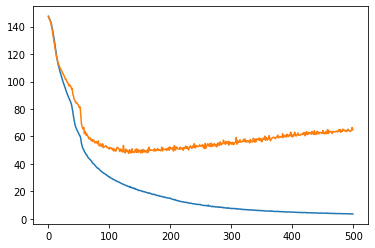

In [0]:
net = Fc_3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9,weight_decay = 0.001)
epoch = 500
train_loss, val_loss = train_valcheck(net,train_loader30,val_loader30,criterion, optimizer, epoch)
plt.plot(train_loss)
plt.plot(64*val_loss)
print("train acc: ",test(net,train_loader30))
print("val acc: ",test(net,val_loader30))

In [0]:
class Fc_4(nn.Module):
  def __init__(self):
    super(Fc_4, self).__init__()
    self.fc1 = nn.Linear(30,30)
    self.fc3 = nn.Linear(30,10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc3(x))
    return x

train acc:  97.8125
val acc:  76.25


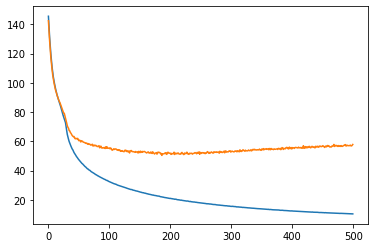

In [0]:
net = Fc_4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum = 0.9,weight_decay = 0.001)
epoch = 500
train_loss, val_loss = train_valcheck(net,train_loader30,val_loader30,criterion, optimizer, epoch)
plt.plot(train_loss)
plt.plot(64*val_loss)
print("train acc: ",test(net,train_loader30))
print("val acc: ",test(net,val_loader30))

In [0]:
model = Fc_4
acc, net2 = kfold_cv(model,10,dataset30,500)

In [0]:
model = Fc_3
acc, net2 = kfold_cv(model,10,dataset30,500)

Train acc 99.02777777777777
Accuracy of 0 st fold is %  78.75
Train acc 99.58333333333333
Accuracy of 1 st fold is %  85.0
Train acc 99.30555555555556
Accuracy of 2 st fold is %  78.75
Train acc 99.44444444444444
Accuracy of 3 st fold is %  76.25
Train acc 99.44444444444444
Accuracy of 4 st fold is %  71.25
Train acc 100.0
Accuracy of 5 st fold is %  78.75
Train acc 100.0
Accuracy of 6 st fold is %  78.75
Train acc 99.86111111111111
Accuracy of 7 st fold is %  83.75
Train acc 99.58333333333333
Accuracy of 8 st fold is %  81.25
Train acc 99.16666666666667
Accuracy of 9 st fold is %  83.75
Average accuracy:  79.625


In [0]:
model = Fc_3
acc, net2 = kfold_cv(model,10,dataset30,200)

Train acc 95.27777777777777
Accuracy of 0 st fold is %  75.0
Train acc 94.44444444444444
Accuracy of 1 st fold is %  70.0
Train acc 95.55555555555556
Accuracy of 2 st fold is %  76.25
Train acc 95.97222222222223
Accuracy of 3 st fold is %  75.0
Train acc 93.47222222222223
Accuracy of 4 st fold is %  76.25
Train acc 93.61111111111111
Accuracy of 5 st fold is %  81.25
Train acc 95.27777777777777
Accuracy of 6 st fold is %  76.25
Train acc 96.25
Accuracy of 7 st fold is %  77.5
Train acc 95.41666666666667
Accuracy of 8 st fold is %  83.75
Train acc 93.33333333333333
Accuracy of 9 st fold is %  77.5
